In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from IPython.display import display # データフレーム表示用関数
import seaborn as sns
import pymc as pm
import arviz as az
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 問題設定
常に確率が一定で、前回の結果が次回に一切影響しない(数学的には「独立な事象」という)くじ引きがあります。<br>
ある人がこのくじ引きを5回引いたところ、結果は「当たり、はずれ、はずれ、当たり、はずれ」でした。 <br>
一回のくじ引きにあたる確率を$p$とするとき、この$p$の値を求めなさい。

### 4.2 Maximum Likelihood Estimation
尤度関数：
$$
f(p) = p^2(1-p)^3
$$

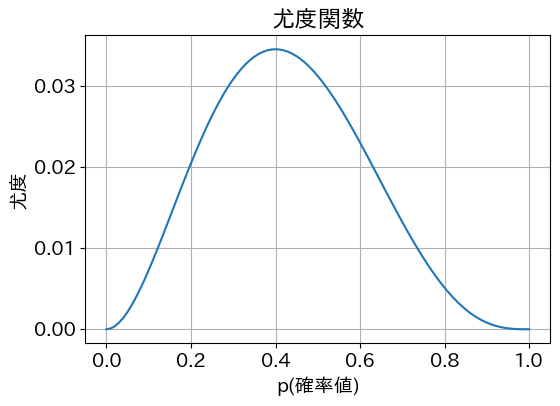

In [2]:
# Code 4.1 尤度関数のグラフ

def likelihood(p):
    return p**2 * (1-p)**3

# 定義域: 0 < p < 1
p = np.arange(0, 1.01, 0.01)

# グラフ描画
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(p, likelihood(p))
plt.xlabel("p(確率値)")
plt.ylabel("尤度")
plt.title(f"尤度関数");


In [3]:
# Code 4.2 最尤推定の繰り返し計算（勾配降下法）の実装

import torch

# 対数尤度関数
def log_likelihood(p):
    return 2*torch.log(p) + 3*torch.log(1-p)

num_epochs = 40 # 繰り返し回数
lr = 0.01           # 学習率

# パラメータ初期値 (p=0.1)
p = torch.tensor(0.1, dtype=torch.float32, requires_grad=True)

logs = np.zeros((0,3))
for epoch in range(num_epochs):
    loss = -log_likelihood(p)       # 損失計算
    loss.backward()                 # 勾配計算
    with torch.no_grad():
        p -= lr * p.grad            # パラメータ修正
        p.grad.zero_()              # 勾配値の初期化
    log = np.array([epoch, p.item(), loss.item()]).reshape(1,-1)
    logs = np.vstack([logs, log])

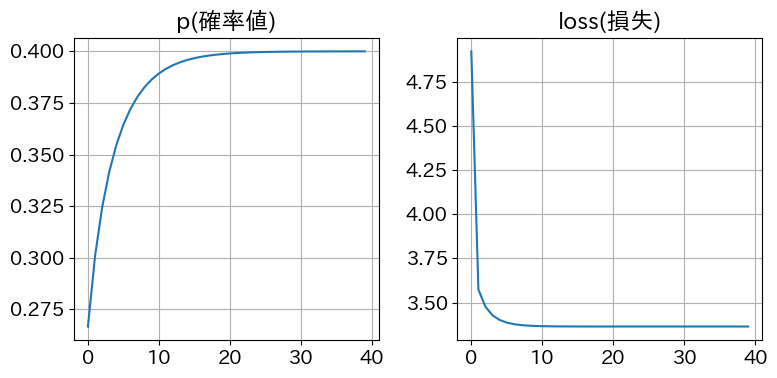

In [4]:
# Code 4.3 繰り返し計算の過程をグラフ表示

plt.rcParams["figure.figsize"] = (8, 4)
fig, axes = plt.subplots(1, 2)
axes[0].plot(logs[:,0], logs[:,1])
axes[0].set_title("p(確率値)")
axes[1].plot(logs[:,0], logs[:,2])
axes[1].set_title("loss(損失)")
plt.tight_layout();


## 4.3~ ベイズ推論

In [5]:
# Code 4.4 データ（観測値）準備

X = np.array([1, 0, 0, 1, 0])
print(X)

[1 0 0 1 0]


In [6]:
# Code 4.5 確率モデル定義

# コンテキスト定義
model1 = pm.Model()
with model1:
    # pm.Uniform: 一様分布
    p = pm.Uniform("p", lower=0.0, upper=1.0)
    # pm.Bernoulli: ベルヌーイ分布
    X_obs = pm.Bernoulli("X_obs", p=p, observed=X)

In [ ]:
# Code 4.6 確率モデルの可視化

g = pm.model_to_graphviz(model1)
display(g)

In [8]:
# Code 4.7 パラメータを明示的に設定してMCMCサンプリング

with model1:
    # inferred data
    idata1_1 = pm.sample(
        chains=3,      # 乱数系列の数(デフォルト2)
        tune=2000,     # 捨てるサンプル数(デフォルト1000)
        draws=2000,    # 取得するサンプル数(デフォルト1000)
        random_seed=42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [p]


Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [9]:
# Code 4.8 デフォルト値でMCMCサンプリング

with model1:
    idata1_2 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


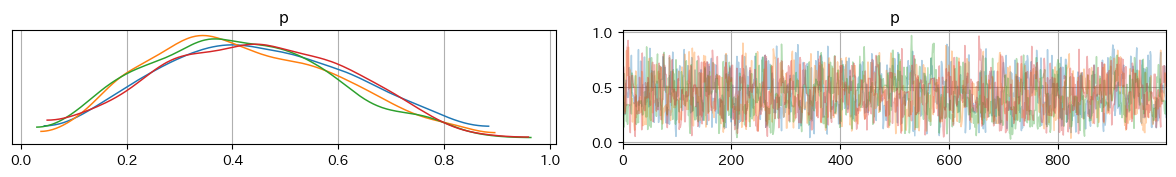

In [10]:
# Code 4.9 サンプリングが正常にできたかを確認（`plot_trace`）

axes = az.plot_trace(idata1_2, compact=False)
plt.tight_layout();

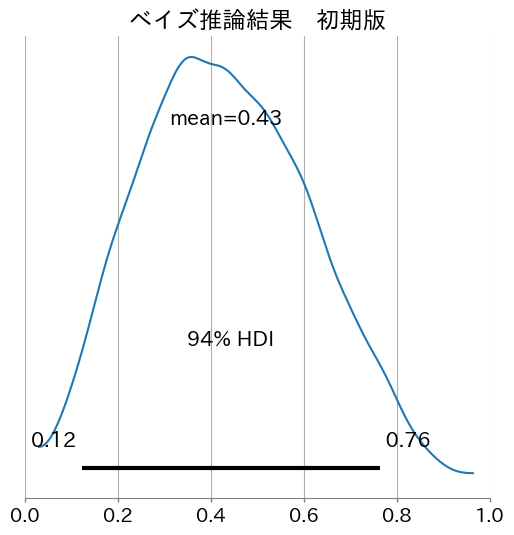

In [11]:
# Code 4.10 事後分布の可視化

plt.rcParams["figure.figsize"] = (6, 6)
ax = az.plot_posterior(idata1_2)
ax.set_xlim(0, 1)
ax.set_title("ベイズ推論結果　初期版");

In [12]:
# Code 4.11 事後分布の統計分析

summary1_2 = az.summary(idata1_2)
display(summary1_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.432,0.177,0.123,0.764,0.004,0.003,1662.000,2567.000,1.000
